<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F1/Core_EDA_Andrew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
path_to_data = 'drive/My Drive/ sample_core_analysis_data_example'

Mounted at /content/drive


# Initializing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2 as cv
import seaborn as sns

from PIL import Image
from skimage import exposure
from skimage import io

import sklearn
import warnings
warnings.filterwarnings('ignore')

## **Functions for getting data** 

In [ ]:
def get_photo(data,i):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(data['photo_id'][i]))

def get_photo_by_id(data,id):
  return io.imread(path_to_data + '/photos/{}.jpeg'.format(id))

def get_mask(data, i):
    return np.load(path_to_data + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'][i], data['task_id'][i]))['data']

def get_json(data,i):
  with open(path_to_data + '/extra/extra_{}__{}.json'.format(data['photo_id'][i],data['task_id'][i])) as json_data:
    d = json.load(json_data)
    json_data.close()
  return d

## **Functions for displaying data**


In [ ]:
def show_image(image,nrows=1,ncols=1,cmap='gray'):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
  ax.imshow(image)
  ax.axis('off')
  return fig, ax

def show_all_photo_data(data,i):
  print(data.iloc[i])
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
  ax1.imshow(get_photo(data, i))
  
  mask = get_mask(data,i)
  cmap = plt.get_cmap('tab20b', np.max(mask) + 1)
  mask = ax2.imshow(mask, cmap=cmap,vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
  ax2.axis('off')
  fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
  return fig, (ax1, ax2)

def show_photo_series(data, column, value):
    fig, ax_ar = plt.subplots(1, 10, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(data, filt_by_photo.index.values[0])
        mask = get_mask(data, filt_by_photo.index.values[0])
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

# **Preprocessing**

In [15]:
all_data = pd.read_csv(path_to_data + '/data.csv')

In [16]:
uv_data = all_data[all_data['photo_type'] == 'УФ']
uv_data.reset_index(inplace = True, drop = True)

# **Machine Learning**

## **SVM**

In [ ]:
y = uv_data['segment_value']
#y = uv_data['segment_value'][:500]

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV


parametrs = {'kernel':('linear', 'rbf'), 'C':[1, 10],'degree':[3,4,5,6,7,8],
             'tol':[1e-3,1e-4,5e-4]}
svc = svm.SVC()

clf = GridSearchCV(svc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

In [ ]:
from sklearn import svm, metrics
from sklearn.model_selection import cross_validate


classifier = svm.SVC(C=10,degree=3,kernel='rbf',tol=0.01)

scores = cross_validate(classifier, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.873193126522839

## **RandomForestClassifier**

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, shuffle=False)


parametrs = {'n_estimators' : [320,330,340],'random_state' : [0],
             'criterion':['gini', 'entropy']}

rfc = RandomForestClassifier()

clf = GridSearchCV(rfc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

{'criterion': 'gini', 'n_estimators': 320, 'random_state': 0}

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


forest = RandomForestClassifier(criterion='entropy',random_state=0)



scores = cross_validate(forest, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.8844559311960862

In [ ]:
scores = cross_val_score(forest, X_test, y_test, cv=5)
scores

array([0.87155963, 0.91743119, 0.89814815, 0.9537037 , 0.90740741])

## **ExtraTrees**

In [ ]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, shuffle=False)


parametrs = {'n_estimators' : [50,100,150,200],'random_state' : [0],
             'criterion':['gini', 'entropy'], 'min_samples_split' : [2,3,4], 'min_samples_leaf' : [1,2,3],'ccp_alpha' : [0.0, 1,2]}

etc = ExtraTreesClassifier()

clf = GridSearchCV(etc,parametrs)


clf.fit(X_train,y_train)

clf.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200,
 'random_state': 0}

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(criterion= 'gini',min_samples_split= 3)

scores = cross_validate(etc, features, y, scoring='f1_macro')

sum(scores['test_score'])/5

0.894450671300018

## **3-chanel histogram with equalization**

In [ ]:
def histogram_equalize(img): 
    img_cdf, bin_centers = exposure.cumulative_distribution(img) 
    return np.interp(img, bin_centers, img_cdf)

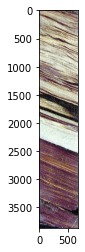

In [ ]:
photo = get_photo(uv_data,0)
photo = histogram_equalize(photo)
plt.imshow(photo)

In [ ]:
def segment_selection_with_mask(img,mask,sugment_num):
  part_of_photo0 = np.ma.masked_where(mask == segment_num, img[:,:,0])
  part_of_photo1 = np.ma.masked_where(mask == segment_num, img[:,:,1])
  part_of_photo2 = np.ma.masked_where(mask == segment_num, img[:,:,2])

  img[:,:,0] = part_of_photo0.data * part_of_photo0.mask
  img[:,:,1] = part_of_photo1.data * part_of_photo1.mask
  img[:,:,2] = part_of_photo2.data * part_of_photo2.mask
  
  return (img,part_of_photo0.mask)

In [ ]:
rgb_features = []
hsv_features = []
from skimage import filters
from skimage.color import rgb2hsv

features_arr = []
for i in range(uv_data.shape[0]):
#for i in range(500):
  segment_num = uv_data['segment_num'].iloc[i]
  photo = get_photo(uv_data,i)
  mask = get_mask(uv_data,i)

  photo1 = histogram_equalize(photo)

  part_of_photo3 = np.ma.masked_where(mask == segment_num, photo1[:,:,0])
  part_of_photo4 = np.ma.masked_where(mask == segment_num, photo1[:,:,1])
  part_of_photo5 = np.ma.masked_where(mask == segment_num, photo1[:,:,2])


  hist3 = np.histogram(part_of_photo3.mask * part_of_photo3.data, bins = 32, range = (0,1))
  hist4 = np.histogram(part_of_photo4.mask * part_of_photo4.data, bins = 32, range = (0,1))
  hist5 = np.histogram(part_of_photo5.mask * part_of_photo5.data, bins = 32, range = (0,1))





  photo = rgb2hsv(photo)
  k = [[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]],[[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]],[[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]]
  s = ndimage.correlate(photo,k)

  part_of_photo0 = np.ma.masked_where(mask == segment_num, photo[:,:,0])
  part_of_photo1 = np.ma.masked_where(mask == segment_num, photo[:,:,1])
  part_of_photo2 = np.ma.masked_where(mask == segment_num, photo[:,:,2])
  print(i)


  hist0 = np.histogram(part_of_photo0.mask * part_of_photo0.data, bins = 32, range = (0,1))
  hist1 = np.histogram(part_of_photo1.mask * part_of_photo1.data, bins = 32, range = (0,1))
  hist2 = np.histogram(part_of_photo2.mask * part_of_photo2.data, bins = 32, range = (0,1))
  
  hist_1 = np.concatenate((np.array(hist0[0][1:] / np.sum(part_of_photo0.mask),dtype=object),
                        np.array(hist1[0][1:] / np.sum(part_of_photo1.mask),dtype=object),
                        np.array(hist2[0][1:] / np.sum(part_of_photo2.mask),dtype=object)))
  
  hist_2 = np.concatenate((np.array(hist3[0][1:] / np.sum(part_of_photo3.mask),dtype=object),
                        np.array(hist4[0][1:] / np.sum(part_of_photo4.mask),dtype=object),
                        np.array(hist5[0][1:] / np.sum(part_of_photo5.mask),dtype=object)))
 
  hsv_features.append(list(hist_1))
  rgb_features.append(list(hist_2))

  hist = np.concatenate((hist_1,hist_2))         
  features_arr.append(list(hist))

## **Selection of important features**

In [ ]:
features = pd.DataFrame(features_arr)

In [ ]:
forest.fit(X_train,y_train)


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
main_features = []
for f in range(X_train.shape[1]):
    main_features.append(indices[f]) 

In [ ]:
f = []
for i in range(70,len(main_features)):
  f.append(main_features[i])

In [ ]:
for i in range(len(f)):
  features.drop(f[i],axis='columns', inplace=True)

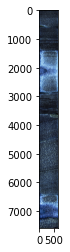

In [ ]:
photo = get_photo(uv_data,1320)

plt.imshow(photo)

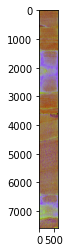

In [ ]:
p = rgb2hsv(photo)

plt.imshow(p)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


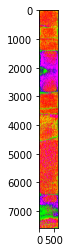

In [ ]:
k = [[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]],[[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]],[[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]]
s = ndimage.correlate(p,k)

plt.imshow(s)

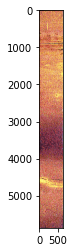

In [ ]:
k = histogram_equalize(photo)

plt.imshow(k)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


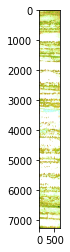

In [ ]:
  plt.imshow(p + k)


# **Segmentation**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


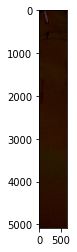

In [158]:
from skimage import filters

photo = get_photo(uv_data,4)

photo = filters.laplace(photo)

plt.imshow(photo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


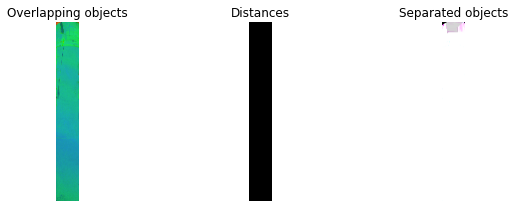

In [147]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.color import rgb2hsv

photo = get_photo(uv_data,4)

photo = rgb2hsv(photo)

distance = ndimage.distance_transform_edt(photo)
local_maxi = peak_local_max(distance, indices=False,labels=photo)
markers = ndimage.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=photo)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(photo, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [143]:
np.unique(labels)

array([   0,    1,    2, ..., 4137, 4138, 4139], dtype=int32)

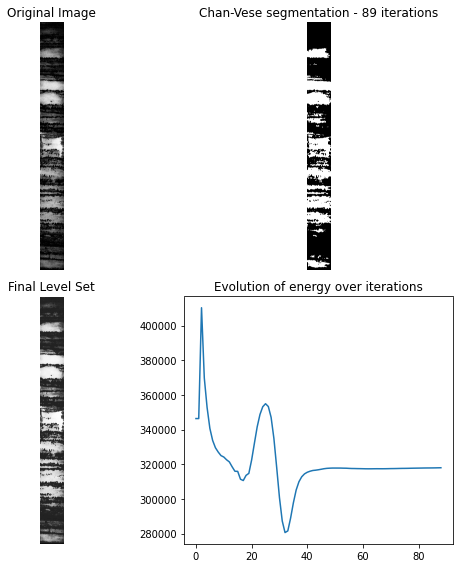

In [194]:
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage.color import rgb2gray

photo = histogram_equalize(photo)

photo = rgb2gray(get_photo(uv_data,1500))
#photo = get_photo(uv_data,1800)


cv = chan_vese(photo, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(photo, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [246]:
def mask_transform(data,i,segment_value):
  photo_data = data[data['photo_id'] == data['photo_id'].iloc[i]]
  photo_data = photo_data[photo_data['segment_value'] == segment_value]
  seg_num = photo_data['segment_num']
  mask = get_mask(data,i)
  for k in seg_num:
    for i in range(mask.shape[0]):
      for j in range(mask.shape[1]):
        if mask[i][j] == k:
          mask[i][j] = 1
        else:
          mask[i][j] = 0
  return mask

In [261]:
from skimage.metrics import (adapted_rand_error,variation_of_information)

mask = mask_transform(uv_data,1500,'Насыщенное')

im_true = ndimage.label(ndimage.binary_fill_holes(mask - 1))[0]

im_test = cv[0]

error, precision, recall = adapted_rand_error(im_true,im_test)
splits, merges = variation_of_information(im_true, im_test)

print(f"Adapted Rand error: {error}")
print(f"Adapted Rand precision: {precision}")
print(f"Adapted Rand recall: {recall}")
print(f"False Splits: {splits}")
print(f"False Merges: {merges}")

Adapted Rand error: 0.30221318920618934
Adapted Rand precision: 0.5358468310547304
Adapted Rand recall: 1.0
False Splits: 0.9476474325374021
False Merges: 0.0


In [262]:
im_test

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [263]:
im_true

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [260]:
for i in range(np.shape(im_test)[0]):
  for j in range(np.shape(im_test)[1]):
    if im_test[i][j] == 1:
      im_test[i][j] = 0
    else:
      im_test[i][j] = 1

In [264]:
im_test = np.multiply(im_test,1)

In [265]:
im_test

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [266]:
from skimage import metrics
metrics.mean_squared_error(im_true,im_test)

0.36612146715157057

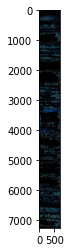

In [201]:
photo = get_photo(uv_data,1500)

p0 = np.ma.masked_where(cv[0] == False,photo[:,:,0])
p1 = np.ma.masked_where(cv[0] == False,photo[:,:,1])
p2 = np.ma.masked_where(cv[0] == False,photo[:,:,2])

photo[:,:,0] = p0.data * p0.mask
photo[:,:,1] = p1.data * p1.mask
photo[:,:,2] = p2.data * p2.mask

plt.imshow(photo)

task_id          53d02fd1_7b6d_4922_85d0_9e88453418a7
photo_id                                      1001557
photo_type                                         УФ
segment_num                                         0
segment_type                                 Свечение
segment_value                              Насыщенное
Name: 1500, dtype: object


(<Figure size 720x720 with 3 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f4d9d63f9e8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f4d9b607cc0>))

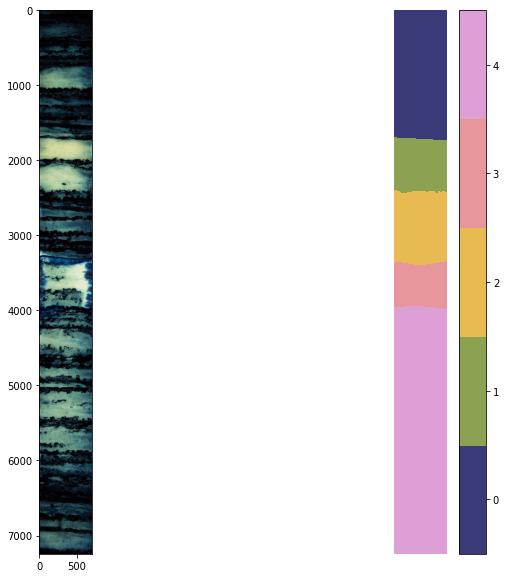

In [202]:
show_all_photo_data(uv_data,1500)

In [206]:
uv_data[uv_data['photo_id'] == uv_data['photo_id'].loc[1500]]

,task_id,photo_id,photo_type,segment_num,segment_type,segment_value
1500,53d02fd1_7b6d_4922_85d0_9e88453418a7,1001557,УФ,0,Свечение,Насыщенное
1501,53d02fd1_7b6d_4922_85d0_9e88453418a7,1001557,УФ,1,Свечение,Насыщенное
1502,53d02fd1_7b6d_4922_85d0_9e88453418a7,1001557,УФ,2,Свечение,Насыщенное
1503,53d02fd1_7b6d_4922_85d0_9e88453418a7,1001557,УФ,3,Свечение,Насыщенное
1504,53d02fd1_7b6d_4922_85d0_9e88453418a7,1001557,УФ,4,Свечение,Насыщенное
